# Lab:  Logistic Regression for Gene Expression Data

In this lab, we use logistic regression to predict biological characteristics ("phenotypes") from gene expression data.  In addition to the concepts in [breast cancer demo](./breast_cancer.ipynb), you will learn to:
* Handle missing data
* Perform multi-class logistic classification
* Create a confusion matrix
* Use L1-regularization for improved estimation in the case of sparse weights (Grad students only)

## Background

Genes are the basic unit in the DNA and encode blueprints for proteins.  When proteins are synthesized from a gene, the gene is said to "express".  Micro-arrays are devices that measure the expression levels of large numbers of genes in parallel.  By finding correlations between expression levels and phenotypes, scientists can identify possible genetic markers for biological characteristics.

The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:
* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  We will see if the characteristics can be predicted from the gene expression levels.  This classification could reveal which genes are potentially involved in Down's syndrome and if drugs and learning have any noticeable effects.


## Load the Data

We begin by loading the standard modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

In [2]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=6, micro=1, releaselevel='final', serial=0)

Use the `pd.read_excel` command to read the data from 

https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls

into a dataframe `df`.  Use the `index_col` option to specify that column 0 is the index.  Use the `df.head()` to print the first few rows.

In [3]:
# TODO
# df = ...
link = "./Data_Cortex_Nuclear.xls"
df = pd.read_excel(link, index_col=0)

df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


This data has missing values.  The site:

http://pandas.pydata.org/pandas-docs/stable/missing_data.html

has an excellent summary of methods to deal with missing values.  Following the techniques there, create a new data frame `df1` where the missing values in each column are filled with the mean values from the non-missing values.

In [4]:
# TODO
# df1 = ...
print("num null df:", df.isnull().sum().sum())
# print("num null df1:", df1.isnull().sum().sum())
df1 = df.fillna(df.mean())
print("Mean^2 Same within:",((df1.mean() - df.mean())**2).sum())
print("num null df:", df.isnull().sum().sum())
print("num null df1:", df1.isnull().sum().sum())

num null df: 1396
Mean^2 Same within: 3.73630409211e-30
num null df: 1396
num null df1: 0


## Binary Classification for Down's Syndrome

We will first predict the binary class label in `df1['Genotype']` which indicates if the mouse has Down's syndrome or not.  Get the string values in `df1['Genotype'].values` and convert this to a numeric vector `y` with 0 or 1.  You may wish to use the `np.unique` command with the `return_inverse=True` option.

In [5]:
# TODO
# y = ...

yraw = df1['Genotype'].values
negVal, posVal = np.unique(yraw)
y = (yraw == posVal).astype(int)

# y1 = (df1['Genotype'].values == np.unique(yraw)[1]).astype(int)


As predictors, get all but the last four columns of the dataframes.  Standardize the data matrix and call the standardized matrix `Xs`.  The predictors are the expression levels of the 77 genes. 

In [6]:
# TODO
# Xs = ...

X = np.array(df1[ df1.columns[:-4] ])
Xs = (X - np.mean(X, axis=0))/np.std(X, axis=0)


Create a `LogisticRegression` object `logreg` and `fit` the training data.

In [7]:
# TODO
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(Xs, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Measure the accuracy of the classifer.  That is, use the `logreg.predict` function to predict labels `yhat` and measure the fraction of time that the predictions match the true labels.  Below, we will properly measure the accuracy on cross-validation data.

In [8]:
# TODO
yhat = logreg.predict(Xs)
print("The accuracy proportion is {:.3f}.".format(np.sum(y == yhat)/len(y)))

The accuracy proportion is 1.000.


## Interpreting the weight vector

Create a stem plot of the coefficients, `W` in the logistic regression model.  You can get the coefficients from `logreg.coef_`, but you will need to reshape this to a 1D array.  

<Container object of 3 artists>

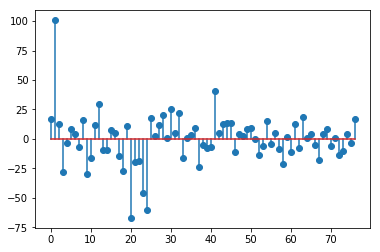

In [9]:
# TODO
W = np.squeeze(logreg.coef_)
plt.stem(W)

You should see that `W[i]` is very large for a few components `i`.  These are the genes that are likely to be most involved in Down's Syndrome.  Although, we do not discuss it in this class, there are ways to force the logistic regression to return a sparse vector `W`.  

Find the names of the genes for two components `i` where the magnitude of `W[i]` is largest.  

In [10]:
# TODO
W_sort_idx = (-abs(W)).argsort()
print("\n".join(df1.columns[W_sort_idx[:2]]))

ITSN1_N
BRAF_N


## Cross Validation

The above meaured the accuracy on the training data.  It is more accurate to measure the accuracy on the test data.  Perform 10-fold cross validation and measure the average precision, recall and f1-score.  Note, that in performing the cross-validation, you will want to randomly permute the test and training sets using the `shuffle` option.  In this data set, all the samples from each class are bunched together, so shuffling is essential.  Print the mean precision, recall and f1-score and error rate across all the folds.

In [11]:
import sklearn
from sklearn import model_selection
from sklearn import metrics
# TODO
nfold = 10

kf = model_selection.KFold(n_splits=nfold,shuffle=True)

prfa = np.zeros((nfold, 4))

print("pre\trecall\tf_1\terr")
for isplit, Ind in enumerate(kf.split(Xs)):
    Itr, Its = Ind
    X_cv_tr = Xs[Itr]
    X_cv_ts = Xs[Its]
    
    y_cv_tr = y[Itr]
    y_cv_ts = y[Its]
    logreg.fit(X_cv_tr, y_cv_tr)
    
    y_hat = logreg.predict(X_cv_ts)

#     print(("{:.3f}\t"*3).format(
#         *metrics.precision_recall_fscore_support(y[Its], y_hat, average='binary')) )
    
    prfa[isplit, :] = metrics.precision_recall_fscore_support(
            y[Its], y_hat, average='binary') #[:3]
    
    prfa[isplit, 3] = 1-np.mean(y[Its]==y_hat)
    
    print(("{:.3f}\t"*4).format(*prfa[isplit, :]))
    
print(("-"*29+"\n"+"{:.3f}\t"*4).format(*np.mean(prfa, axis=0)))

pre	recall	f_1	err
0.962	0.962	0.962	0.037	
0.978	0.918	0.947	0.046	
0.952	0.952	0.952	0.037	
0.931	1.000	0.964	0.037	
0.980	0.943	0.962	0.037	
0.918	0.957	0.938	0.056	
0.906	0.941	0.923	0.074	
0.936	0.957	0.946	0.046	
0.966	0.933	0.949	0.056	
0.981	0.945	0.963	0.037	
-----------------------------
0.951	0.951	0.951	0.046	


## Multi-Class Classification

Now use the response variable in `df1['class']`.  This has 8 possible classes.  Use the `np.unique` funtion as before to convert this to a vector `y` with values 0 to 7.

In [12]:
# TODO
# y = ...
yraw = df1['class']
le = preprocessing.LabelEncoder()
le.fit(yraw)
y = le.transform(yraw)

# with unique
y = np.zeros_like(yraw)
yraw = df1['class']
col_names = np.unique(yraw)
nam2num = dict([*zip(col_names, np.arange(8))])

y = np.array([*map((lambda x : nam2num[x]), yraw)])

Fit a multi-class logistic model by creating a `LogisticRegression` object, `logreg` and then calling the `logreg.fit` method.

In [13]:
# TODO
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(Xs, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Measure the accuracy on the training data.

In [14]:
# TODO
print("Acc: {:.3f}%".format(100*np.mean(logreg.predict(Xs) == y)))

Acc: 100.000%


Now perform 10-fold cross validation, and measure the confusion matrix `C` on the test data in each fold. You can use the `confustion_matrix` method in the `sklearn` package.  Add the confusion matrix counts across all folds and then normalize the rows of the confusion matrix so that they sum to one.  Thus, each element `C[i,j]` will represent the fraction of samples where `yhat==j` given `ytrue==i`.  Print the confusion matrix.  You can use the command

    print(np.array_str(C, precision=4, suppress_small=True))
    
to create a nicely formatted print.  Also print the overall mean and SE of the test error rate across the folds.

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# TODO
nfold = 10

kf = model_selection.KFold(n_splits=nfold,shuffle=True)

logreg = linear_model.LogisticRegression()

C = np.zeros((len(col_names),len(col_names)))

for isplit, Ind in enumerate(kf.split(Xs)):
    Itr, Its = Ind
 
    X_cv_tr = Xs[Itr]
    X_cv_ts = Xs[Its]
    
    y_cv_tr = y[Itr]
    y_cv_ts = y[Its]
    
    
    logreg.fit(X_cv_tr, y_cv_tr)
    
    y_hat = logreg.predict(X_cv_ts)
    
    C += confusion_matrix(y_hat, y_cv_ts)

C = C / np.sum(C, axis=1)
# print(np.array_str(C, precision=4, suppress_small=True))

# errMean = 1-np.sum(C*np.eye(8))/8
# errStd = np.std(C)

acc = np.diagonal(C)
mu = np.mean(acc)
sigma = np.std(acc)
print("The mean and SE of the test error are {:.3f} and {:.3f} respectively."
      .format(mu, sigma/np.sqrt(nfold-1)))

The mean and SE of the test error are 0.988 and 0.005 respectively.


0.98	0.01	0.00	0.01	0.01	0.00	0.00	0.00	
0.01	0.98	0.00	0.00	0.01	0.00	0.00	0.00	
0.00	0.00	1.00	0.00	0.00	0.00	0.00	0.00	
0.00	0.00	0.00	1.00	0.00	0.00	0.00	0.00	
0.02	0.01	0.00	0.00	0.96	0.00	0.01	0.00	
0.00	0.00	0.00	0.00	0.00	1.00	0.00	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	1.00	0.00	
0.00	0.00	0.01	0.00	0.00	0.00	0.00	0.99	


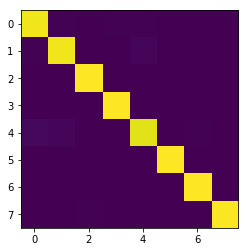

In [16]:
print("\n".join([("{:.2f}\t"*row.shape[0]).format(*row) for row in C]))
plt.imshow(C)

Re-run the logistic regression on the entire training data and get the weight coefficients.  This should be a 8 x 77 matrix.  Create a stem plot of the first row of this matrix to see the coefficients on each of the genes.

<Container object of 3 artists>

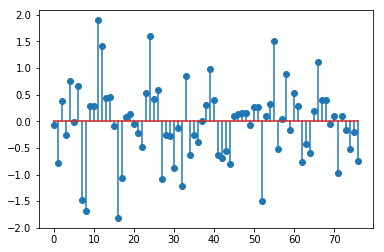

In [17]:
# TODO
logreg.fit(Xs, y)
W = logreg.coef_
plt.stem(W[0,:])

## L1-Regularization

Graduate students only complete this section.

In most genetic problems, only a limited number of the tested genes are likely influence any particular attribute.  Hence, we would expect that the weight coefficients in the logistic regression model should be sparse.  That is, they should be zero on any gene that plays no role in the particular attribute of interest.  Genetic analysis commonly imposes sparsity by adding an l1-penalty term.  Read the `sklearn` [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the `LogisticRegression` class to see how to set the l1-penalty and the inverse regularization strength, `C`.

Using the model selection strategies from the [prostate cancer analysis demo](../model_sel/prostate.ipynb), use K-fold cross validation to select an appropriate inverse regularization strength.  
* Use 10-fold cross validation 
* You should select around 20 values of `C`.  It is up to you find a good range.
* Make appropriate plots and print out to display your results
* How does the accuracy compare to the accuracy achieved without regularization.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


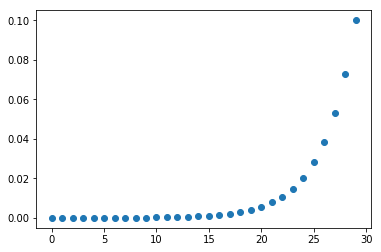

In [18]:
logreg = linear_model.LogisticRegression()
print(logreg)
Cs = np.logspace(-5, -1, 30)
plt.plot(Cs, 'o')

In [19]:
# TODO
nfold = 10
Cs = np.logspace(-1, 2, 20)

def testCs(Cs, nfold):
    kf = model_selection.KFold(n_splits=nfold,shuffle=True)
    acc = np.zeros((nfold, len(Cs)))

    for isplit, Ind in enumerate(kf.split(Xs)):
        Itr, Its = Ind

        X_cv_tr = Xs[Itr]
        X_cv_ts = Xs[Its]

        y_cv_tr = y[Itr]
        y_cv_ts = y[Its]

        for ic, c in enumerate(Cs):
            logreg = linear_model.LogisticRegression(C=c, penalty='l1')
            logreg.fit(X_cv_tr, y_cv_tr)

            y_hat = logreg.predict(X_cv_ts)

            acc[isplit, ic] = np.mean(y_hat == y_cv_ts)
    #         print(np.mean(y_hat == y_cv_ts))

        print(np.array([*zip(Cs, acc[isplit, :])]).shape)
    #     plt.figure()
    #     plt.plot([*zip(Cs, acc)])

    #     plt.plot(Cs, acc, label=isplit)
    #     plt.legend()
    return acc

acc = testCs(Cs, nfold)
accMean = np.mean(acc, axis=0)
acc.shape

(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)


(10, 20)

(10, 20)
(20,)
0.88586679041
	C	acc	stdErr	0.990812075734
	001.83	0.99167	0.00085	True
 	000.89	0.99167	0.00072	True
 	016.24	0.99074	0.00103	False
 	001.27	0.99074	0.00080	False
 	011.29	0.99074	0.00103	False
 	023.36	0.98981	0.00097	False
 	000.62	0.98981	0.00072	False
 	007.85	0.98981	0.00126	False
 	002.64	0.98889	0.00090	False
 	033.60	0.98889	0.00128	False



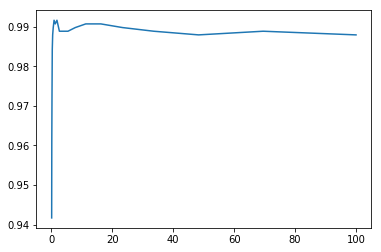

In [20]:
def oneStdErrRule(Cs, acc):
    accMean = np.mean(acc, axis=0)
    accStdErr  = np.std(acc, axis=0) / (nfold-1)
    print(acc.shape)
    print(accMean.shape)
    plt.plot(Cs, accMean)
    srtIdx = (-accMean).argsort()

    optC = Cs[srtIdx[0]]
    trgtAcc = accMean[srtIdx[0]]-accStdErr[srtIdx[0]]

    asGoodIdx = accMean[srtIdx[:10]] >= trgtAcc
    
    print(min(Cs[srtIdx[:10]][asGoodIdx]))
    
    print("\tC\tacc\tstdErr\t"+str(trgtAcc))
    print(*[ ("\t{:06.2f}\t{:.5f}\t{:.5f}\t{}"+"\n").format(*x) for x in zip(
                 Cs[srtIdx[:10]], 
                 accMean[srtIdx[:10]], 
                 accStdErr[srtIdx[:10]],
                 asGoodIdx)
               ]
        )
    return optC

optC = oneStdErrRule(Cs, acc)

Searching around optC=1.8329807108324356
CsToTry: [  0.01832981   0.04604239   0.11565326   0.29050787   0.72972276
   1.83298071   3.25955186   5.79639395  10.30760802  18.32980711]
(10, 2)
(10, 2)
(10, 2)
(10, 2)
(10, 2)
(10, 2)
(10, 2)
(10, 2)
(10, 2)
(10, 2)
(10, 10)
(10,)
1.83298071083
	C	acc	stdErr	0.99148453399
	001.83	0.99259	0.00111	True
 	003.26	0.99259	0.00111	True
 	005.80	0.99259	0.00111	True
 	010.31	0.99259	0.00111	True
 	018.33	0.99259	0.00111	True
 	000.73	0.99074	0.00122	False
 	000.29	0.98148	0.00138	False
 	000.12	0.95000	0.00154	False
 	000.05	0.86481	0.00231	False
 	000.02	0.67130	0.00602	False



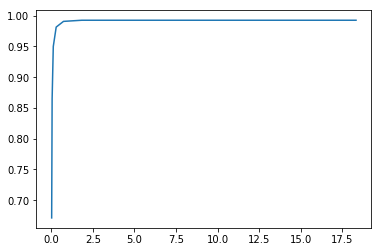

In [21]:
# TODO
print("Searching around optC={}".format(optC))
nfold = 10
numC=10

sm = np.logspace(np.log10(optC), np.log10(optC)-2, 1 + numC / 2)
lg = np.logspace(np.log10(optC), np.log10(optC)+1, numC / 2)


CsToTry = np.hstack((sm[::-1][:-1], lg))
print("CsToTry:",CsToTry)

acc = testCs(CsToTry, nfold)

noptC = oneStdErrRule(CsToTry, acc)


In [22]:
from sklearn.model_selection import cross_val_score

regModel   = linear_model.LogisticRegression(C=noptC, penalty='l1')
regAcc     = 100*cross_val_score(regModel, Xs, y, cv=nfold)

unRegModel = linear_model.LogisticRegression()
unRegAcc     = 100*cross_val_score(unRegModel, Xs, y, cv=nfold)

print("The accuracy of the unregularized model is {:.3f}% ± {:.3f}%"
          .format(np.mean(unRegAcc), np.std(unRegAcc)/np.sqrt(nfold-1)))

print("The accuracy of the regularized model is {:.3f}% ± {:.3f}%"
          .format(np.mean(regAcc), np.std(regAcc)/np.sqrt(nfold-1)))

The accuracy of the unregularized model is 86.463% ± 2.370%
The accuracy of the regularized model is 88.062% ± 2.390%


For the optimal `C`, fit the model on the entire training data with l1 regularization. Find the resulting weight matrix, `W_l1`.  Plot the first row of this weight matrix and compare it to the first row of the weight matrix without the regularization.  You should see that, with l1-regularization, the weight matrix is much more sparse and hence the roles of particular genes are more clearly visible.

1.83298071083


<Container object of 3 artists>

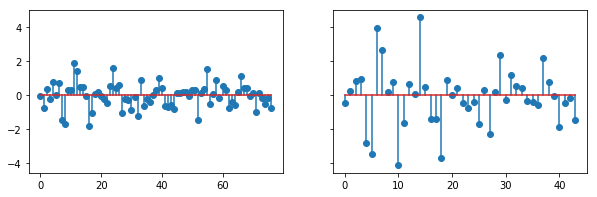

In [23]:
# TODO
print(noptC)
model = linear_model.LogisticRegression(C=noptC, penalty='l1')
model.fit(Xs, y)


f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
f.set_size_inches(10, 3)
ax1.stem(W[0,:])
ax2.stem(model.coef_[0, model.coef_[0,:] != 0])

In [24]:
cvModel = linear_model.LogisticRegressionCV(
    Cs=np.linspace(1e-2,100, 20), 
    cv=10, 
    penalty='l1',
    solver='liblinear',
    n_jobs=-1,
    verbose=0,
    refit=True)

cvModel.fit(Xs, y)

LogisticRegressionCV(Cs=array([  1.00000e-02,   5.27263e+00,   1.05353e+01,   1.57979e+01,
         2.10605e+01,   2.63232e+01,   3.15858e+01,   3.68484e+01,
         4.21111e+01,   4.73737e+01,   5.26363e+01,   5.78989e+01,
         6.31616e+01,   6.84242e+01,   7.36868e+01,   7.89495e+01,
         8.42121e+01,   8.94747e+01,   9.47374e+01,   1.00000e+02]),
           class_weight=None, cv=10, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=-1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)

In [25]:
print(np.min(cvModel.C_), np.mean(cvModel.C_), np.max(cvModel.C_))


S = np.zeros(20)
for i in cvModel.scores_:
    score = cvModel.scores_[i]
    S += np.mean(score, axis=0)
print(i)
S /= (i+1)
print(S[np.argsort(-S)])
optIdx = np.argmax(S)
S[optIdx]

print(np.mean(cvModel.C_))
cvModel.C_


5.27263157895 42.7688815789 100.0
7
[ 0.96192407  0.96169241  0.96168597  0.96167954  0.96144788  0.9613417
  0.9613417   0.9613417   0.96133526  0.96132883  0.96122909  0.96122265
  0.96111004  0.9611036   0.96109073  0.96075933  0.96074003  0.96063385
  0.96063385  0.87404762]
42.7688815789


array([  10.53526316,    5.27263158,   78.94947368,   42.11105263,
          5.27263158,  100.        ,   42.11105263,   57.89894737])